In [3]:
import pandas as pd
import os

Countries = 'FRDE'
Country1 = Countries[:2]
Country2 = Countries[2:]

# Set the desired folder path
folder_path = f'..\..\data\datasets\EPF2_{Countries}'

# Change the current working directory
os.chdir(folder_path)
# Load the CSV files
df_pred_bi = pd.read_csv(f'MLP_TSCHORA_EPF2_{Countries}_test_predictions.csv')
df_real_bi = pd.read_csv('test.csv')


# Set the desired folder path
folder_path = f'..\EPF2_{Country1}'
# Change the current working directory
os.chdir(folder_path)
# Load the CSV files
df_pred_1 = pd.read_csv(f'MLP_TSCHORA_EPF2_{Country1}_test_predictions.csv')
df_real_1 = pd.read_csv('test.csv')

# Set the desired folder path
folder_path = f'..\EPF2_{Country2}'
# Change the current working directory
os.chdir(folder_path)
# Load the CSV files
df_pred_2 = pd.read_csv(f'MLP_TSCHORA_EPF2_{Country2}_test_predictions.csv')
df_real_2 = pd.read_csv('test.csv')

In [4]:
# Rename the columns of df_pred
new_columns = {}
for hour in range(24):
    new_columns[str(hour)] = f'{Country1}_price_{hour}'
    new_columns[str(hour + 24)] = f'{Country2}_price_{hour}'
df_pred = df_pred_bi.rename(columns=new_columns)

# Rename the columns of df_pred_1 and df_pred_2
new_columns_1, new_columns_2 = {}, {}
for hour in range(24):
    new_columns_1[str(hour)] = f'{Country1}_price_{hour}'
    new_columns_2[str(hour)] = f'{Country2}_price_{hour}'
df_pred_1, df_pred_2 = df_pred.rename(columns=new_columns_1), df_pred.rename(columns=new_columns_2)

# Concatenate the dataframes
df_pred_single = pd.concat([df_pred_1, df_pred_2], axis=1)
df_real_single = pd.concat([df_real_1, df_real_2], axis=1)

In [5]:
# Initialize a counter for correct predictions
correct_predictions_bi = 0
correct_predictions_single = 0

# Iterate over each hour
for hour in range(24):
    # Create columns for the current hour
    country1_hour_col = f'{Country1}_price_{hour}'
    country2_hour_col = f'{Country2}_price_{hour}'

    # Ensure that the columns exist
    assert country1_hour_col in df_pred_bi.columns and country2_hour_col in df_pred_bi.columns, f"Hour {hour} columns are missing in predictions"
    assert country1_hour_col in df_real_bi.columns and country2_hour_col in df_real_bi.columns, f"Hour {hour} columns are missing in real prices"
    
        # Ensure that the columns exist
    assert country1_hour_col in df_pred_single.columns and country2_hour_col in df_pred_single.columns, f"Hour {hour} columns are missing in predictions"
    assert country1_hour_col in df_real_single.columns and country2_hour_col in df_real_single.columns, f"Hour {hour} columns are missing in real prices"

    # Create a new column that indicates which country has a higher price at the current hour
    df_pred_bi['higher_price_country'] = df_pred_bi[[country1_hour_col, country2_hour_col]].idxmax(axis=1)
    df_real_bi['higher_price_country'] = df_real_bi[[country1_hour_col, country2_hour_col]].idxmax(axis=1)
    df_pred_single['higher_price_country'] = df_pred_single[[country1_hour_col, country2_hour_col]].idxmax(axis=1)
    df_real_single['higher_price_country'] = df_real_single[[country1_hour_col, country2_hour_col]].idxmax(axis=1)

    # Compare the two dataframes and count the number of times the prediction matches the reality
    correct_predictions_bi += (df_pred_bi['higher_price_country'] == df_real_bi['higher_price_country']).sum()
    correct_predictions_single += (df_pred_single['higher_price_country'] == df_real_single['higher_price_country']).sum()

# Calculate the accuracy for the multiple output method
total_predictions_bi = len(df_pred_bi) * 24
accuracy_bi = correct_predictions_bi / total_predictions_bi

# Calculate the accuracy for the single output method
total_predictions_single = len(df_pred_single) * 24
accuracy_single = correct_predictions_single / total_predictions_single

print(f'The accuracy of the predictions with multiple output of the higher price of electricty between {Country1} and {Country2} is {accuracy_bi:.2f}')
print(f'The accuracy of the predictions with single output of the higher price of electricty between {Country1} and {Country2} is {accuracy_single:.2f}')

The accuracy of the predictions of the higher price of electricty between FR and DE is 0.76


In [6]:
total_outcome_bi = 0
total_outcome_single = 0

# Iterate over each row (day)
for _, row in df_pred_bi.iterrows():
    # Iterate over each hour
    for hour in range(24):
        country1_price_pred = row[f'{Country1}_price_{hour}']
        country2_price_pred = row[f'{Country2}_price_{hour}']
        country1_price_real = df_real_bi.at[_, f'{Country1}_price_{hour}']
        country2_price_real = df_real_bi.at[_, f'{Country2}_price_{hour}']

        # Buy from the country with the lower predicted price and sell to the country with the higher predicted price
        if country1_price_pred < country2_price_pred:
            total_outcome_bi += country2_price_real - country1_price_real
        else:
            total_outcome_bi += country1_price_real - country2_price_real
            
# Iterate over each row (day)
for _, row in df_pred_single.iterrows():
    # Iterate over each hour
    for hour in range(24):
        country1_price_pred = row[f'{Country1}_price_{hour}']
        country2_price_pred = row[f'{Country2}_price_{hour}']
        country1_price_real = df_real_single.at[_, f'{Country1}_price_{hour}']
        country2_price_real = df_real_single.at[_, f'{Country2}_price_{hour}']

        # Buy from the country with the lower predicted price and sell to the country with the higher predicted price
        if country1_price_pred < country2_price_pred:
            total_outcome_single += country2_price_real - country1_price_real
        else:
            total_outcome_single += country1_price_real - country2_price_real

print(f'The total outcome of the strategy based on the prediction with single output on the test period is {total_outcome_single:.2f}€')

The total outcome of the strategy based on the prediction on the test period is 123333.89€


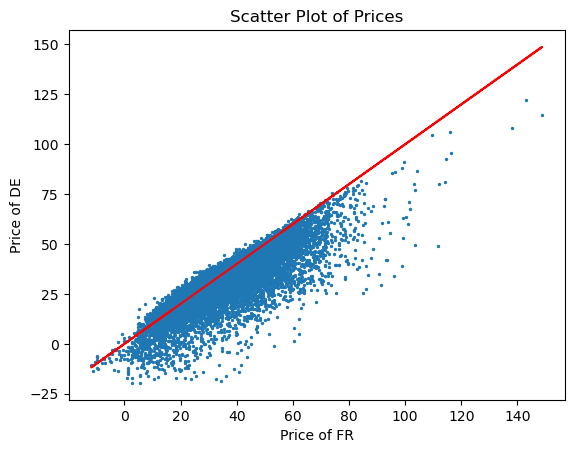

In [7]:
import matplotlib.pyplot as plt

# Extract the price columns for Country1 and Country2
country1_prices = df_pred_bi[[f'{Country1}_price_{hour}' for hour in range(24)]].values.flatten()
country2_prices = df_pred_bi[[f'{Country2}_price_{hour}' for hour in range(24)]].values.flatten()

# Plot the scatter plot
plt.scatter(country1_prices, country2_prices, s=2)
# Add the line y=x
plt.plot(country1_prices, country1_prices, color='red')

# Set the labels and title
plt.xlabel(f'Price of {Country1}')
plt.ylabel(f'Price of {Country2}')
plt.title('Scatter Plot of Prices (Multiple Output)')

# Show the plot
plt.show()

# Extract the price columns for Country1 and Country2
country1_prices = df_pred_single[[f'{Country1}_price_{hour}' for hour in range(24)]].values.flatten()
country2_prices = df_pred_single[[f'{Country2}_price_{hour}' for hour in range(24)]].values.flatten()

# Plot the scatter plot
plt.scatter(country1_prices, country2_prices, s=2)
# Add the line y=x
plt.plot(country1_prices, country1_prices, color='red')

# Set the labels and title
plt.xlabel(f'Price of {Country1}')
plt.ylabel(f'Price of {Country2}')
plt.title('Scatter Plot of Prices (Single Output)')

# Show the plot
plt.show()